In [2]:
# %pip install tensorflow tqdm pillow matplotlib ipykernel scikit-learn 

<a target="_blank" href="https://colab.research.google.com/github/naddeoa/yt-data/blob/master/thumbnails.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Set up the model

In [3]:
import logging
from sklearn.decomposition import PCA
import os

# Quiet a few noisy logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
# logging.disable(logging.CRITICAL)
tf.get_logger().setLevel('WARNING')

from tensorflow import keras
from tensorflow.keras import layers
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import PIL
from typing import List, Dict, Union, Tuple, Optional
import PIL.Image
# from multiprocess import Pool
from sklearn.decomposition import PCA
import numpy as np
from functools import partial
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Flatten, LeakyReLU, Concatenate, GaussianNoise, Dropout

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))




/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num GPUs Available:  1


In [4]:

def is_notebook():
    try:
        # Check if the 'get_ipython' function exists
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True  # Running in a Jupyter notebook
        else:
            return False  # Running
    except Exception:
        return False


def is_colab():
    try:
        import google.colab
        return True
    except ModuleNotFoundError:
        return False

def create_batches(lst, batch_size):
    """Yield successive n-sized batches from lst."""
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

# Hyper parameters

In [5]:
# Hyper parameters
latent_dim = 250
BATCH_SIZE = 1

generator_learning_rate = 0.0002
discriminator_learning_rate = generator_learning_rate * 1.2

# -1 is totally different, 0 not similar, 1 is identical
similarity_threshold = 0
similarity_penalty = 5


# learning_rate = 0.001 # super high
beta_1=0.9


total_epochs_so_far = 0

In [6]:
# fancy generator
def build_generator(latent_dim):
    generator = Sequential(name='Generator')

    generator.add(Dense(256, input_dim=latent_dim))
    generator.add(LeakyReLU(alpha=0.2))
    # generator.add(GaussianNoise(0.2)) 

    generator.add(Dense(512))
    generator.add(LeakyReLU(alpha=0.2))
    # generator.add(GaussianNoise(0.2)) 

    generator.add(Dense(1000, activation='relu'))

    generator.add(Dense(8 * 8 * 256, activation='relu'))
    generator.add(Dropout(0.2)) 

    generator.add(Reshape((8, 8, 256)))

    generator.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu' ))

    # generator.add(Dense(512, activation='relu'))
    # generator.add(Dense(1000, activation='relu'))

    generator.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', activation='tanh' ))

    generator.summary()
    return generator



def build_discriminator():
    discriminator = Sequential(name='Discriminator')
    discriminator.add(layers.Conv2D(32, (3, 3), strides=(2, 2),  input_shape=(64, 64, 3), padding='same', activation='relu' ))
    # discriminator.add(GaussianNoise(0.2)) 
    discriminator.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu' ))
    # discriminator.add(GaussianNoise(0.2)) 
    discriminator.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu' ))
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(1, activation='sigmoid'))

    discriminator.summary()
    # discriminator.trainable = False
    return discriminator


# Combine the generator and discriminator into a GAN
def build_gan(generator, discriminator):
    # discriminator.trainable = False
    model = keras.Sequential([
        generator,
        discriminator
    ])
    return model



# Build one to validate it
build_gan(build_generator(latent_dim), build_discriminator())

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               64256     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1000)              513000    
                                                                 
 dense_3 (Dense)             (None, 16384)             16400384  
                                                                 
 dropout (Dropout)           (None, 16384)             0 

# Image viz utils


In [7]:


def visualize_image_distribution(images):
    # Flatten all pixel values into a single list
    all_pixels = np.array(images).flatten()

    # Plot a histogram for the pixel values
    plt.hist(all_pixels, bins=256, color='gray', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

def visualize_image_scatter(images):
    # Flatten each image into a 1D array
    flattened_images = np.array([img.flatten() for img in images])

    # Apply PCA with 2 components
    pca = PCA(2)
    reduced_data = pca.fit_transform(flattened_images)

    # Plot the reduced data as a scatter plot
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
    plt.title('PCA Scatter Plot')
    plt.show()


def compare_scatters(dataset1, dataset2, name1='Dataset 1', name2='Dataset 2'):
    global total_epochs_so_far
    plt.cla()
    plt.clf()
    # Flatten each image into a 1D array
    flattened_images1 = np.array([img.flatten() for img in dataset1])
    flattened_images2 = np.array([img.flatten() for img in dataset2])

    # Apply PCA with 2 components
    pca = PCA(2)

    # Fit PCA on the combined datasets and transform each separately
    pca.fit(np.concatenate((flattened_images1, flattened_images2)))
    reduced_data1 = pca.transform(flattened_images1)
    reduced_data2 = pca.transform(flattened_images2)

    # Plot the reduced data as a scatter plot
    plt.scatter(reduced_data1[:, 0], reduced_data1[:, 1], label=name1, alpha=0.5)
    plt.scatter(reduced_data2[:, 0], reduced_data2[:, 1], label=name2, alpha=0.5)
    plt.title('PCA Scatter Plot')
    plt.legend()
    if is_notebook():
        plt.show()
    else:
        # Ensure predictions exists
        if not os.path.exists('predictions'):
            os.mkdir('predictions')
        plt.savefig(f'predictions/latest-plot.jpg')
        plt.savefig(f'predictions/plot-{total_epochs_so_far}.jpg')


def process_prediction_image(image):
    # Scale the image from [-1, 1] to [0, 1]
    image = (image + 1) / 2
    # Clip values to [0, 1] in case of any numerical instability
    image = tf.clip_by_value(image, 0, 1)
    # Convert the image tensor to a NumPy array
    return image.numpy()


def visualize_preprocessed_image(image):
    image = process_prediction_image(image)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()


def visualize_thumbnails(image_list, rows, cols):
    global total_epochs_so_far
    plt.cla()
    plt.clf()
    # Create a grid of subplots to display the images
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 10))

    # Iterate over the subplots and plot the generated images
    for i, ax in enumerate(axs.flat):
        # Rescale the pixel values from -1 to 1 to the range 0 to 255
        image = process_prediction_image(image_list[i])
        # image = process_prediction_image(image)
        ax.imshow(image)
        ax.axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    # Show the plot
    if is_notebook():
        plt.show()
    else:
        # Ensure predictions exists
        if not os.path.exists('predictions'):
            os.mkdir('predictions')
        plt.savefig(f'predictions/latest.jpg')
        plt.savefig(f'predictions/thumbnail-{total_epochs_so_far}.jpg')

def show_samples(generator, latent_dim, rows=1, cols=8, noise=tf.random.normal([8, latent_dim]), dataset=None):
    generated_thumbnails = generator.predict(noise)
    # for it in generated_thumbnails:
        # visualize_preprocessed_image(it)
    visualize_thumbnails(generated_thumbnails, rows, cols)

    if dataset is not None:
        # generated = [generator.predict(tf.random.normal([1, latent_dim])) for i in range(100)]
        compare_scatters(dataset, generated_thumbnails)

In [8]:

# Define the loss functions
def discriminator_loss(real_output, fake_output) -> Tuple[tf.Tensor, Tuple[tf.Tensor, tf.Tensor]]:
    real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
    disc_loss = real_loss + fake_loss
    return disc_loss, (real_loss, fake_loss)


# def generator_loss(fake_output, real_output):
    # return tf.reduce_mean(tf.square(tf.reduce_mean(fake_output, axis=0) - tf.reduce_mean(real_output, axis=0)))

def generator_loss(fake_output):
    gen_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)
    return gen_loss



In [9]:

# Define the optimizero
generator_optimizer = keras.optimizers.Adam(learning_rate=generator_learning_rate, beta_1=beta_1)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=discriminator_learning_rate, beta_1=beta_1)

if is_colab():
    weight_path = "/content/drive/MyDrive/thumbnail-project/weights"
else:
    weight_path = "./model/weights"
    # Make sure model dir exists
    if not os.path.exists("./model"):
        os.mkdir("./model")

# Training loop
@tf.function
def train_step(images,  gan, generator, discriminator, epoch, generator_every, discriminator_every):
    # noise = tf.random.normal([BATCH_SIZE, latent_dim]) # Defined globally before training
    noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, latent_dim))
    noise2 = np.random.uniform(-1, 1, size=(BATCH_SIZE, latent_dim))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        generated_images2 = generator(noise2, training=True)
        similarity = tf.keras.losses.cosine_similarity(generated_images, generated_images2)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss, (real_loss, fake_loss) = discriminator_loss(real_output, fake_output)

        # Penalize similarity
        similarity_score = tf.reduce_mean(similarity) 
        if similarity_score < similarity_threshold:
            penalty = similarity_penalty * tf.abs(similarity_score)
            gen_loss += penalty

    # Apparently this has to happen after the with context exits. ML people...
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    if generator_every > 0 and  epoch % generator_every == 0:
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    if discriminator_every > 0 and epoch % discriminator_every== 0:
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    return disc_loss, gen_loss, (real_loss, fake_loss), similarity_score  # Return the discriminator loss as batch_loss

def load_weights(gan):
    try:
        gan.load_weights(weight_path)
        print("Loaded previous weights")
    except Exception as e:
        print(e)


def trunc(loss):
    '''Truncate loss values for display in tqdm'''
    return f'{loss:.8f}'

def train(dataset, epochs, gan, generator, discriminator, samples_after=100, discriminator_every=1, generator_every=1):
    global total_epochs_so_far
    # progress_bar_epochs = tqdm(range(epochs), desc='Epochs', position=0)
    load_weights(gan)
    
    for epoch in range(epochs):
        total_epochs_so_far = total_epochs_so_far + 1
        # progress_bar_epochs.update(1)
        
        batched_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(len(dataset)).batch(BATCH_SIZE)
        progress_bar_batches = tqdm(batched_dataset, position=0, leave=False)
        for image_batch in progress_bar_batches:
            disc_loss, gen_loss, (real_loss, fake_loss), similarity_score   = train_step(image_batch, gan, generator, discriminator, generator_every=generator_every, discriminator_every=discriminator_every, epoch=epoch)
            
            # progress_bar_batches.update(1)
            progress_bar_batches.set_postfix({'Epoch': epoch, 'Similarity': trunc(similarity_score.numpy()), 'Gen Loss': trunc(gen_loss.numpy()), 'Disc loss': trunc(disc_loss.numpy()), ' Disc Real Loss': trunc(real_loss.numpy()), 'Disc Fake Loss': trunc(fake_loss.numpy())})
        
        # progress_bar_batches.close()

        # Update the gan model weights by setting the generator and discriminator weights
        # gan.set_weights(generator.get_weights() + discriminator.get_weights())

        # Get some samples every 20 epochs
        if samples_after is not None and epoch % samples_after == 0:
            show_samples(generator, latent_dim, dataset=dataset)
            # Also print all of the loss info and similarity score
            print(f'Epoch {epoch} | Similarity: {similarity_score.numpy()} | Gen Loss: {gen_loss.numpy()} | Disc Loss: {disc_loss.numpy()} | Disc Real Loss: {real_loss.numpy()} | Disc Fake Loss: {fake_loss.numpy()} ')
            # print(f'Epoch {epoch} | Gen Loss: {gen_loss.numpy()} | Disc Loss: {disc_loss.numpy()} | Disc Real Loss: {real_loss.numpy()} | Disc Fake Loss: {fake_loss.numpy()}')


        gan.save_weights(weight_path)



    




# Download the dataset

In [10]:
import os
import tarfile


if is_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Specify the path to the directory containing the TGZ file
    directory_path = "/content/drive/MyDrive/thumbnail-project"

    # List the contents of the directory
    os.listdir(directory_path)



In [11]:
# This might already be done from before


if is_colab():
    # # # Specify the path to the TGZ file
    tgz_file_path = f"{directory_path}/thumbnails.tgz"
    extract_path = '/tmp/thumbnails' # Extract to local dir because I/O is horrible on google drive

    # # # Open the TGZ file
    with tarfile.open(tgz_file_path, 'r:gz') as tar:
        # Extract all files in the TGZ archive
        tar.extractall(path=extract_path)

    extract_data_dir = f'{extract_path}/data'
else:
    extract_data_dir = '/home/anthony/workspace/yt-data/data/'

print(f'Thumbnails in {extract_data_dir}')


Thumbnails in /home/anthony/workspace/yt-data/data/


In [12]:
# List the files in the extracted directory
# extract_path = f'{directory_path}/thumbnails'
file_list = os.listdir(extract_data_dir)
print(file_list[:10])
print(f'Found {len(file_list)} total files')
jpg_file_list = [file for file in file_list if file.endswith(".jpg")]
print(f'Found {len(jpg_file_list)} jpgs')

['v4HLml2Nme8.jpg', 'yDAj48iq4w8.json', 'pE9Qjif6K90.json', 'e1RSD8xLjJ8.json', 'YJKy8FehDUo.json', 'oQkn5feunx0.jpg', 'SzZutCq2-Tc.json', 'qjWLM0DDD_g.json', 'RkZNyux07aQ.json', '_7HvkhauoF8.json']
Found 52214 total files
Found 26107 jpgs


In [13]:

thumbnail_data: List[Tuple[str, str]] = [] # tuples of (path, id)

# Process or use the extracted files
for file_name in jpg_file_list:
    file_path = os.path.join(extract_data_dir, file_name)
    thumbnail_data.append((file_path, file_name.replace('.jpg', '')))

print(thumbnail_data[:10])
print(f'Found {len(thumbnail_data)} thumbnails')

[('/home/anthony/workspace/yt-data/data/v4HLml2Nme8.jpg', 'v4HLml2Nme8'), ('/home/anthony/workspace/yt-data/data/oQkn5feunx0.jpg', 'oQkn5feunx0'), ('/home/anthony/workspace/yt-data/data/IPE-3x3GFWw.jpg', 'IPE-3x3GFWw'), ('/home/anthony/workspace/yt-data/data/kbcshufA-Io.jpg', 'kbcshufA-Io'), ('/home/anthony/workspace/yt-data/data/20aG024pmLc.jpg', '20aG024pmLc'), ('/home/anthony/workspace/yt-data/data/FPYKl2X5xAc.jpg', 'FPYKl2X5xAc'), ('/home/anthony/workspace/yt-data/data/uR58CT3GksQ.jpg', 'uR58CT3GksQ'), ('/home/anthony/workspace/yt-data/data/GVNHqrNFBUA.jpg', 'GVNHqrNFBUA'), ('/home/anthony/workspace/yt-data/data/fmhkZq0NdKY.jpg', 'fmhkZq0NdKY'), ('/home/anthony/workspace/yt-data/data/Ptg2bhLcoRY.jpg', 'Ptg2bhLcoRY')]
Found 26107 thumbnails


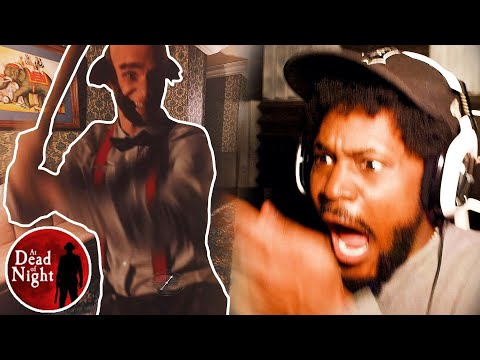

In [14]:
PIL.Image.open(thumbnail_data[0][0])

In [15]:
import numpy as np
from PIL import Image
# def load_and_preprocess_image(file_path):
#     try:
#         image = tf.io.read_file(file_path)
#         image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image
#         image = tf.image.resize(image, [64, 64])
#         image = tf.cast(image, tf.float32)
#         image = (image / 255.0)  # Normalize to [0, 1]
#         image = (image - 0.5) * 2  # Scale to [-1, 1]
#         return image
#     except Exception as e:
#         print(e)

def load_and_preprocess_image(img_path, target_size=(64, 64)):
    # Open the image file
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize(target_size)
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # If it's a grayscale image, convert it to RGB
    if len(img_array.shape) == 2:
        img_array = np.repeat(img_array[:, :, np.newaxis], 3, axis=2)
    
    # Normalize from [0, 255] to [-1, 1]
    img_array = (img_array.astype('float32') - 127.5) / 127.5
    return img_array

# repeat the first item in thumbnail_data 10 times
# bad_data = [load_and_preprocess_image(thumbnail_data[0][0])] * 20000
# dataset = bad_data
# len(dataset)


dataset = [load_and_preprocess_image(t[0]) for t in tqdm(thumbnail_data[:2000])] 
# dataset = dataset * BATCH_SIZE
len(dataset )

100%|██████████| 2000/2000 [00:03<00:00, 543.50it/s]


2000

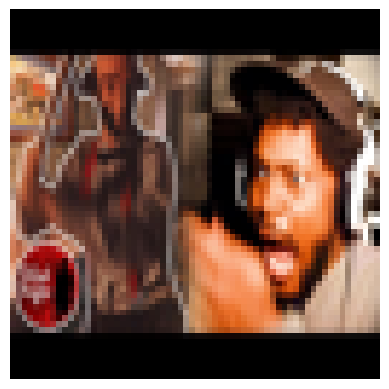

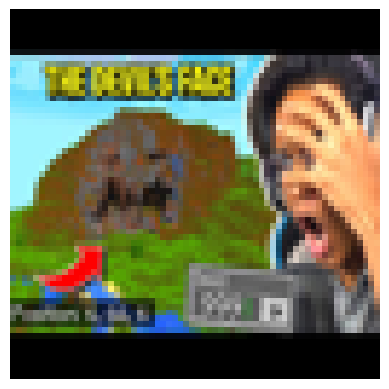

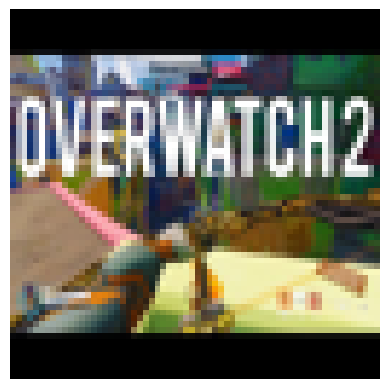

In [16]:
# Make sure the preprocessing worked


for image in dataset[:3]:
    visualize_preprocessed_image(image)


# Train the model

In [17]:


generator = build_generator(latent_dim)
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
load_weights(gan)


Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               64256     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1000)              513000    
                                                                 
 dense_8 (Dense)             (None, 16384)             16400384  
                                                                 
 dropout_1 (Dropout)         (None, 16384)             0 

In [18]:
EPOCHS = 100000
# BATCH_SIZE = 120
# Train the GAN
train(dataset, EPOCHS, gan=gan, discriminator=discriminator, generator=generator, samples_after=2, discriminator_every=2, generator_every=1)


Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./model/weights


KeyboardInterrupt: 

# Make some stuff


In [ ]:

from PIL import Image
noise = tf.random.normal([1, latent_dim])

show_samples(generator, latent_dim, noise=noise)

In [ ]:
# visualize_thumbnails(generated_thumbnails)
load_weights(gan)
show_samples(generator, latent_dim)

1/1 [==============================] - 0s 20ms/step


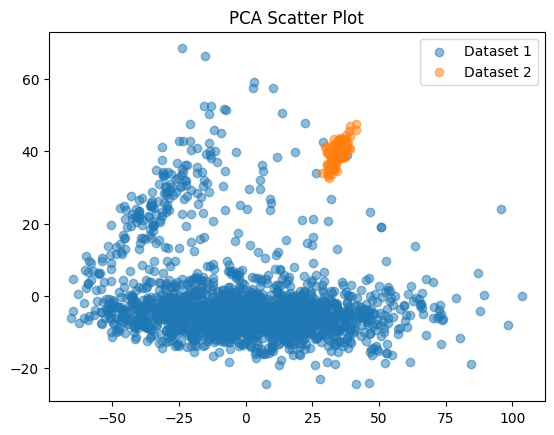

In [42]:
# visualize_image_scatter(dataset)
generated = [generator.predict(tf.random.normal([1, latent_dim])) for i in range(100)]
# visualize_image_scatter(generated )
compare_scatters(dataset, generated)


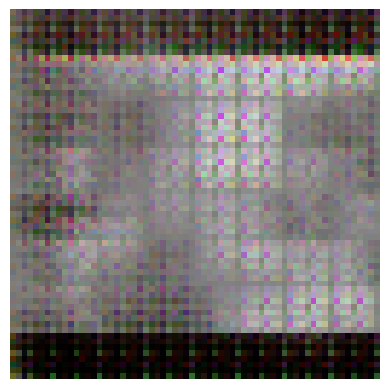

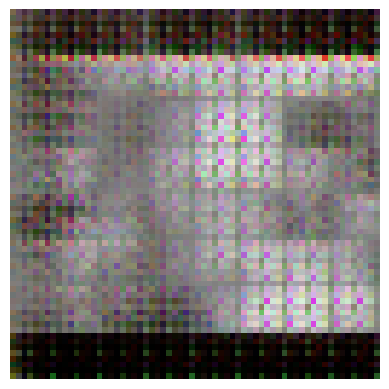

-0.940737605
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [29]:
# Test similarity

noise = np.random.uniform(-1, 1, size=(BATCH_SIZE * 2, latent_dim))
noise2 = np.random.uniform(-1, 1, size=(BATCH_SIZE, latent_dim))

generated_images = generator(noise, training=True)
generated_images2 = generator(noise2, training=True)

visualize_preprocessed_image(generated_images[0]) 
visualize_preprocessed_image(generated_images2[0]) 

# visualize_preprocessed_image(dataset[0]) 
# visualize_preprocessed_image(dataset[2]) 

similarity = tf.keras.losses.cosine_similarity(generated_images, generated_images2)

tf.print(tf.reduce_mean(similarity))

In [33]:

for i in range(1000):
    noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, latent_dim))
    generated_images = generator(noise, training=True)

In [40]:

noise = np.random.uniform(-1, 1, size=(100, latent_dim))
generated_images = generator(noise, training=True)
len(generated_images)

def create_batches(lst, batch_size):
    """Yield successive n-sized batches from lst."""
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

batches = list(create_batches(generated_images, 1))
len(batches[0][0])


64